# Setup
**For full setup read all 'NOTE:' comments and that should be enough**

# NOTE: ctrl+shift+I and paste it to console
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

NOTE: AFTER RESETING RUNTIME ENABLE GPU ACCELERATION!

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

######### GLOBAL VIARIABLES SETUP ##########
##### NOTE: change directories to right ones #####
DIR_DETECTOR = "/content/drive/My Drive/Colab Content/GoldBagDetector/"  # Will cd here
DIR_DATASET = "dataset-combined/" 
PRETRAINED_MODEL = DIR_DATASET + "models/detection_model-ex-020--loss-0001.557.h5"
# PRETRAINED_MODEL = DIR_DATASET + "models/detection_model-ex-104--loss-2.93.h5"
global_id = 0 # To stop threads ath the end of program it's changed
print("Version should be 3.12.2 or higher. Otherwise upgrade protobuf")
!pip show protobuf | grep Version
%cd $DIR_DETECTOR


print("Dir check below. Good is no output:")
import os
if not os.path.exists(DIR_DETECTOR):
  print("Path DIR_DETECTOR does not exist")
if not os.path.exists(DIR_DATASET):
  print("Path DIR_DATASET does not exist")
if not os.path.exists(PRETRAINED_MODEL):
  print("Path PRETRAINED_MODEL does not exist")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Version should be 3.12.2 or higher. Otherwise upgrade protobuf
Version: 4.0.0rc1
/content/drive/My Drive/Colab Content/GoldBagDetector
Dir check below. Good is no output:


# On Error: __init__() got an unexpected keyword argument 'read_only_collections'

If validation does not work reinstall protobuf and restart runtime

In [2]:
!pip uninstall --yes protobuf
!pip install 'protobuf>=3.0.0a3'

Uninstalling protobuf-3.12.2:
  Successfully uninstalled protobuf-3.12.2
     |████████████████████████████████| 1.3MB 3.5MB/s 
ERROR: tensorflow-metadata 0.22.2 has requirement protobuf<4,>=3.7, but you'll have protobuf 4.0.0rc1 which is incompatible.


Auth *pydrive* and install tensorflow

In [2]:
%cd $DIR_DETECTOR

# Init Drive autocleaner
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)


!pip3 install tensorflow-gpu==1.13.1
!pip3 install imageai --upgrade

import tensorflow as tf
if tf.test.gpu_device_name() != "/device:GPU:0":
  raise EnvironmentError("NO GPU ACCELERATION ENABLED")
else:
  print("GPU GOOD")

/content/drive/My Drive/Colab Content/GoldBagDetector
     |████████████████████████████████| 345.2MB 47kB/s 
     |████████████████████████████████| 3.2MB 27.7MB/s 
     |████████████████████████████████| 368kB 39.8MB/s 
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
     |████████████████████████████████| 184kB 3.5MB/s 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

OSError: ignored

# Training

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name() != "/device:GPU:0":
  raise EnvironmentError("NO GPU ACCELERATION ENABLED")

# %cd /
%cd $DIR_DETECTOR

import os
import time
import glob
import random
import threading
from imageai.Detection.Custom import DetectionModelTrainer

######## VARIABLES ########
RUN_THREADS = True
JOB_DONE = False
THREAD_SLEEP = 300 # 300 = 5 min
global_id = 0
MODELS_TO_KEEP = 8  # NOTE: change depending on free space on drive

######## FUNCTIONS ########
def get_sorted_models_list():
    model_list = glob.glob(DIR_DATASET + "models/*.h5")
    # Sort by time modified oldest first
    model_list = sorted(model_list, key=os.path.getmtime) 
    return model_list

def auto_clean_drive_trash():
  global my_drive

  try:
    files_list = my_drive.ListFile({'q': "trashed = true"}).GetList()
    print("Trash files to delete ({}): ".format(len(files_list)))
    for file in files_list:
      print("Trash \"{}\" deleted permanently.".format(file["title"]))
      file.Delete()
  except Exception:
    pass

def manage_model_files(ID):
  '''
    Keep only best performing models
    And autoclean trash
  '''
  global RUN_THREADS, THREAD_SLEEP, global_id

  while True:
    model_list = get_sorted_models_list()

    # Shuffle worst performers
    tmp_list = model_list[:-3]
    random.shuffle(tmp_list)
    model_list[:-3] = tmp_list

    if len(model_list) > MODELS_TO_KEEP:
      print("TOO MANY MODELS. LIST:")
      print(model_list)
      
      # Delete one bad model (shuffled)
      print("Deleting: %s" % (model_list[0]))
      os.remove(model_list[0])

    # Autoclean Drive trash
    auto_clean_drive_trash()

    # Sleep
    for i in range(THREAD_SLEEP):
      if RUN_THREADS is False or ID != global_id:
        return
      time.sleep(1)


def log_time(ID):
  global RUN_THREADS, THREAD_SLEEP, global_id

  while True:
    print (time.ctime())

    filename = "my_log.txt"
    if os.path.exists(filename):
      append_write = 'a' # append if already exists
    else:
      append_write = 'w' # make a new file if not

    f = open(filename, append_write)
    f.write("{}\n{}\n".format(time.ctime(), get_sorted_models_list()))
    f.close()

    # Sleep
    for i in range(THREAD_SLEEP):
      if RUN_THREADS is False or ID != global_id:
        return
      time.sleep(1)
    

######## MAIN PROGRAM ########
# Run thread for file management
global_id = time.time()
t1 = threading.Thread(target=manage_model_files, kwargs=dict(ID=global_id))
t2 = threading.Thread(target=log_time, kwargs=dict(ID=global_id))
t1.start()
t2.start()

#Train model
##### NOTE: change train_from_pretrained_model to newest model every rerun #####
##### NOTE: change object_names_array= if data class have changed #####
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory=DIR_DATASET)
trainer.setTrainConfig(object_names_array=["goldbag"], batch_size=4,
                       num_experiments=150, 
                       train_from_pretrained_model=PRETRAINED_MODEL)
trainer.trainModel()

print("Execution done. Going to sleep for 1 min")
RUN_THREADS = False
global_id = 0
time.sleep(60)


/content/drive/My Drive/Colab Content/GoldBagDetector


Using TensorFlow backend.


Fri Jul 17 22:49:29 2020
Generating anchor boxes for training images and annotation...
Files to delete (3): 
"detection_model-ex-024--loss-0001.548.h5" deleted permanently.
Average IOU for 9 anchors: 0.85
Anchor Boxes generated.
"detection_model-ex-022--loss-0001.550.h5" deleted permanently.
Detection configuration saved in  dataset-combined/json/detection_config.json
"detection_model-ex-016--loss-0001.617.h5" deleted permanently.
Training on: 	['goldbag']
Training with Batch Size:  4
Number of Experiments:  150
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Training with transfer learning from pretrained Model


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Instructions for updating:
Use tf.cast instead.
Epoch 1/150
935/936 [============================>.] - ETA: 0s - loss: 2.8885 - yolo_layer_1_loss: 0.9769 - yolo_layer_2_loss: 0.9317 - yolo_layer_3_loss: 0.9799Fri Jul 17 23:04:34 2020
Files to delete (0): 
936/936 [==============================] - 896s 958ms/step - loss: 2.8876 - yolo_layer_1_loss: 0.9760 - yolo_layer_2_loss: 0.9310 - yolo_layer_3_loss: 0.9805 - val_loss: 0.4005 - val_yolo_layer_1_loss: 0.8739 - val_yolo_layer_2_loss: 1.3876 - val_yolo_layer_3_loss: 1.5730
Epoch 2/150
935/936 [============================>.] - ETA: 0s - loss: 2.3454 - yolo_layer_1_loss: 0.5403 - yolo_layer_2_loss: 0.8277 - yolo_layer_3_loss: 0.9775Fri Jul 17 23:19:35 2020
Files to delete (0): 
936/936 [==============================] - 808s 863ms/step - loss: 2.3488 - yolo_layer_1_loss: 0.5397 - yolo_layer_2_loss: 0.8273 - yolo_layer_3_loss: 0.9819 - val_loss: 1.2806 - val_yolo_layer_1_loss: 0.7999 - val_yolo_layer_2_loss: 1.0411 - val_yolo_layer_3_los

# Evaluation

In [3]:
%cd $DIR_DETECTOR

from imageai.Detection.Custom import DetectionModelTrainer

trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory=DIR_DATASET)
trainer.evaluateModel(model_path=DIR_DATASET + "models", json_path=DIR_DATASET + "json/detection_config.json", iou_threshold=0.8, object_threshold=0.9, nms_threshold=0.5)

/content/drive/My Drive/Colab Content/GoldBagDetector


Using TensorFlow backend.


Starting Model evaluation....
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model File:  dataset-combined/models/detection_model-ex-002--loss-0002.349.h5 

Using IoU :  0.8
Using Object Threshold :  0.9
Using Non-Maximum Suppression :  0.5
goldbag: 0.8114
mAP: 0.8114
Model File:  dataset-combined/models/detection_model-ex-004--loss-0002.118.h5 

Using IoU :  0.8
Using Object Threshold :  0.9
Using Non-Maximum Suppression :  0.5
goldbag: 0.7479
mAP: 0.7479
Model File:  dataset-combined/models/detection_model-ex-009--loss-0001.666.h5 

Using IoU :  0.8
Using Object Threshold :  0.9
Using Non-Maximum Suppression :  0.5
goldbag: 0.8423
mAP: 0.8423
Model File:  dataset-combined/models/detection_model-ex-010--loss-0001.524.h5 

Using IoU :  0.8
Using Object Threshold :  0.9
Using Non-Maximum Suppression :  0.5
goldbag: 0.8526
mAP: 0.8526
Model File:  dataset-combined/models/detection_model-ex-014--loss-0001.504.h5 

Using IoU :  0.8
Using Object Threshold :  0.9
Using Non-Maximum Suppression :  0.5
goldbag: 0.8666
mAP: 0.8666
Model File:  dataset-combined/models/det

[{'average_precision': {'goldbag': 0.8114028348482847},
  'map': 0.8114028348482847,
  'model_file': 'dataset-combined/models/detection_model-ex-002--loss-0002.349.h5',
  'using_iou': 0.8,
  'using_non_maximum_suppression': 0.5,
  'using_object_threshold': 0.9},
 {'average_precision': {'goldbag': 0.7479088623547651},
  'map': 0.7479088623547651,
  'model_file': 'dataset-combined/models/detection_model-ex-004--loss-0002.118.h5',
  'using_iou': 0.8,
  'using_non_maximum_suppression': 0.5,
  'using_object_threshold': 0.9},
 {'average_precision': {'goldbag': 0.8423105015539873},
  'map': 0.8423105015539873,
  'model_file': 'dataset-combined/models/detection_model-ex-009--loss-0001.666.h5',
  'using_iou': 0.8,
  'using_non_maximum_suppression': 0.5,
  'using_object_threshold': 0.9},
 {'average_precision': {'goldbag': 0.8526007165301166},
  'map': 0.8526007165301166,
  'model_file': 'dataset-combined/models/detection_model-ex-010--loss-0001.524.h5',
  'using_iou': 0.8,
  'using_non_maximum_s

# Test Model

Save path: dataset-combined/evaluation-images/014--loss-0001.504.h5/IMG375.jpg
goldbag  :  55.435603857040405  :  [530, 137, 634, 203]
Detected: 44/45


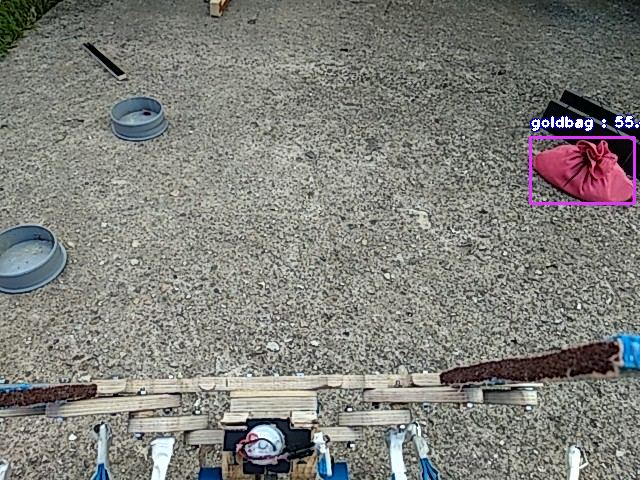

Save path: dataset-combined/evaluation-images/014--loss-0001.504.h5/IMG170.jpg
goldbag  :  59.61405634880066  :  [136, 349, 305, 463]
Detected: 45/46


KeyboardInterrupt: ignored

In [5]:
%cd $DIR_DETECTOR

from imageai.Detection.Custom import CustomObjectDetection
import os
import cv2
from google.colab.patches import cv2_imshow
import glob
import time
import random

detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setJsonPath(DIR_DATASET + "json/detection_config.json")

models = glob.glob(DIR_DATASET + "models/*.h5")
models = sorted(models, key=os.path.getmtime, reverse=True) # Sort by time modified best first
print("All models: {}".format(models))

validation_imgs = glob.glob(DIR_DATASET + "validation/images/*.jpg")
random.shuffle(validation_imgs)
print("Validation images: {}".format(validation_imgs))

for model in models: # [0:2]:
  print("#################################")
  print("#################################")
  print("##############MODEL##############")
  print("Validating model: {}".format(model))
  print("#################################")
  print("#################################")

  print("Showing max 25 random images per model")
  detector.setModelPath(model)
  detector.loadModel()

  count_detections = 0
  count_img = 0
  for img in validation_imgs: # [:25]:
    count_img += 1
    frame = cv2.imread(img)

    frame_out, detections = detector.detectObjectsFromImage(input_type="array", input_image=frame,
    output_type="array", minimum_percentage_probability=10)

    save_path = DIR_DATASET + "evaluation-images/{}/{}".format(model[-21:], img[-10:])
    print("Save path: {}".format(save_path))
    # if not os.path.exists(save_path):
    #         os.makedirs(save_path)
    # cv2.imwrite(frame_out, save_path)

    for eachObject in detections:
      count_detections += 1
      print(eachObject["name"] , " : ", eachObject["percentage_probability"], " : ", eachObject["box_points"] )

    print("Detected: {}/{}".format(count_detections, count_img))
    cv2_imshow(frame_out)